# My Basic Sentiment Analysis

### 1. Importing Libraries

In [5]:
import nltk
import random
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.classify import ClassifierI
from statistics import mode

%matplotlib inline

### 2. Check training data

In [2]:
data = pd.read_csv("fifa_world_cup_2022_tweets.csv")
data.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


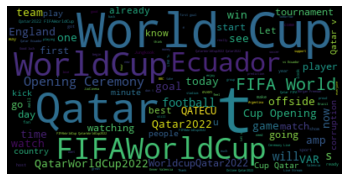

In [6]:
### generate word cloud

# creating stopword list
STOPWORDS.update(["br", "href", "http", "https", "WorldCup2022", "CO"])
alltext = " ".join(review for review in data.Tweet)
wordcloud = WordCloud(stopwords=STOPWORDS).generate(alltext)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

<AxesSubplot: xlabel='Sentiment', ylabel='Count'>

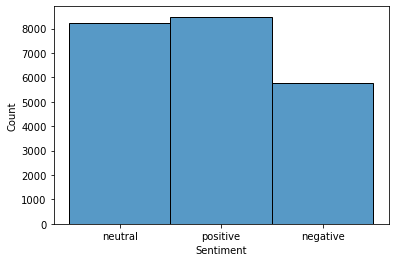

In [7]:
# check number of occurences of each sentiment
sns.histplot(data=data, x="Sentiment")

In [8]:
### generate positive, neutral and negative wordclouds
pos_text = " ".join(review for review in data[data['Sentiment'] == "positive"].Tweet)
neu_text = " ".join(review for review in data[data['Sentiment'] == "neutral"].Tweet)
neg_text = " ".join(review for review in data[data['Sentiment'] == "negative"].Tweet)

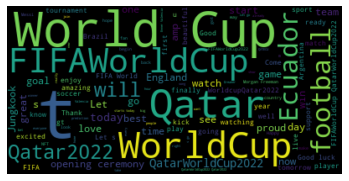

In [9]:
# positive wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS).generate(pos_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordclouda.png')
plt.show()

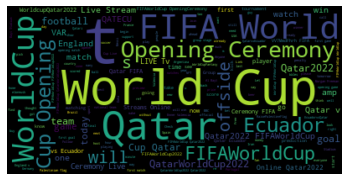

In [10]:
# neutral wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS).generate(neu_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudb.png')
plt.show()

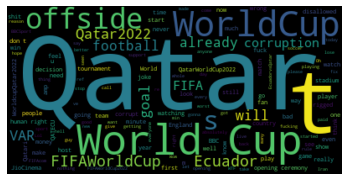

In [11]:
# negative wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS).generate(neg_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudc.png')
plt.show()

### 3. Data Cleaning

In [12]:
# remove line breaks ('\n')
def remove_linebreak(text):
    return " ".join(text.split("\n"))

# remove punctuation
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
# remove hashtags and refs to sites and and users
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        t = '#hashtag' if t.startswith('#') and len(t) > 1 else t
        new_text.append(t)
    return " ".join(new_text)

In [13]:
data['Tweet'] = data['Tweet'].apply(remove_punctuation)
data['Tweet'] = data['Tweet'].apply(remove_linebreak)
data['Tweet'] = data['Tweet'].apply(preprocess)
data.head(10)

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @user @user @user...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @user #hashtag launch video Shows how...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #hashtag http,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright http #hashtag #...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative
5,5,2022-11-20 23:57:32+00:00,0,Twitter for Android,"And like, will the mexican fans be able to scr...",negative
6,6,2022-11-20 23:57:06+00:00,0,Twitter for Android,Look like a only me and the Jamaican football ...,neutral
7,7,2022-11-20 23:57:05+00:00,0,Twitter for Android,Really Football on a Monday morning at 9 and 1...,negative
8,8,2022-11-20 23:56:10+00:00,1,Twitter for iPhone,"As the World Cup starts in Qatar, it’s Black A...",positive
9,9,2022-11-20 23:56:08+00:00,0,Twitter for iPhone,#hashtag @user &amp @user go together so well ...,positive


In [14]:
data_new = data[['Tweet','Sentiment']]
data_new.head()

,Tweet,Sentiment
0,What are we drinking today @user @user @user...,neutral
1,Amazing @user #hashtag launch video Shows how...,positive
2,Worth reading while watching #hashtag http,positive
3,Golden Maknae shinning bright http #hashtag #...,positive
4,"If the BBC cares so much about human rights, h...",negative


In [15]:
# removing @user, http, #hashtag and words starting with &
def get_relevant_info(text):
    text_list = text.split(" ")
    return " ".join(x for x in text_list if x not in ["@user", "http", "#hashtag", "&amp"]).lower()

data_new['Tweet'] = data_new['Tweet'].apply(get_relevant_info)
data_new.head()

C:\Users\chris\AppData\Local\Temp\ipykernel_15552\3430491972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['Tweet'] = data_new['Tweet'].apply(get_relevant_info)


,Tweet,Sentiment
0,what are we drinking today,neutral
1,amazing launch video shows how much the face ...,positive
2,worth reading while watching,positive
3,golden maknae shinning bright,positive
4,"if the bbc cares so much about human rights, h...",negative


### 4. Creating training and test data

In [16]:
# random split

index = data_new.index
data_new['random_number'] = np.random.randn(len(index))
train = data_new[data_new['random_number'] <= 0.8]
test = data_new[data_new['random_number'] > 0.8]

C:\Users\chris\AppData\Local\Temp\ipykernel_15552\999400541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['random_number'] = np.random.randn(len(index))


In [17]:
# creating bag of words
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Tweet'])
test_matrix = vectorizer.transform(test['Tweet'])

### 5. Training

In [18]:
# training model
classifier = MultinomialNB()

X_train = train_matrix
X_test = test_matrix
y_train = train['Sentiment']
y_test = test['Sentiment']

classifier.fit(X_train,y_train)

MultinomialNB()

### 6. Evaluation

In [19]:
predictions = classifier.predict(X_test)

In [20]:
## classification report
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

    negative       0.81      0.62      0.70      1648
     neutral       0.50      0.73      0.59      1241
    positive       0.77      0.70      0.74      1932

    accuracy                           0.68      4821
   macro avg       0.69      0.68      0.68      4821
weighted avg       0.72      0.68      0.69      4821



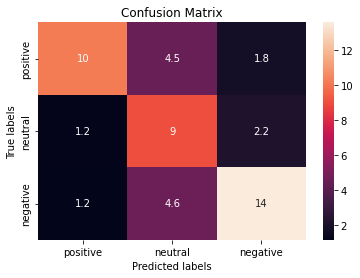

In [22]:
## confusion matrix

cm = confusion_matrix(predictions, y_test) * 0.01
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'neutral', 'negative']); ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative']) 
plt.show()